## Modelling for Full Backs

### Preprocessing

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

final_df = pd.read_csv("plch_uncorr_elo_v2.csv")

# 1. Filter for "Att Mid / Wingers"
df_fb = final_df[final_df["Position"] == "Fullbacks"].copy()

df_fb

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Carries into Penalty Area,Miscontrols,Dispossessed,Fouls Committed,Fouls Drawn,Offsides,Ball Recoveries,Aerials Won,overall,Elo
6,Andrew Robertson,1994-03-11,PremierLeague,Liverpool,Left,Scotland,Fullbacks,2482,0.00,0.04,...,0.22,0.91,0.47,0.40,0.29,0.11,3.81,0.25,82,1993
8,Trent Alexander-Arnold,1998-10-07,PremierLeague,Liverpool,Right,England,Fullbacks,2365,0.11,0.23,...,0.34,0.72,0.57,0.42,0.34,0.04,5.02,0.11,86,1993
12,Kostas Tsimikas,1996-05-12,PremierLeague,Liverpool,Left,Greece,Fullbacks,837,0.00,0.11,...,0.22,0.65,0.43,0.97,0.65,0.11,3.33,0.54,78,1993
14,Conor Bradley,2003-07-09,PremierLeague,Liverpool,Right,Northern Ireland,Fullbacks,754,0.00,0.24,...,1.07,1.55,0.60,1.43,1.67,0.12,6.09,1.31,77,1993
20,Jurriën Timber,2001-06-17,PremierLeague,Arsenal,Right,Netherlands,Fullbacks,2417,0.04,0.11,...,0.41,1.23,0.89,1.15,1.08,0.22,3.50,0.82,82,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,Matthew Sorinola,2001-02-19,EFLChampionship,Plymouth Argyle,Right,England,Fullbacks,1674,0.00,0.05,...,0.16,1.72,0.48,1.02,2.26,0.05,4.41,0.59,66,1443
601,Joe Edwards,1990-10-31,EFLChampionship,Plymouth Argyle,Right,England,Fullbacks,1136,0.08,0.08,...,0.00,1.27,0.63,1.66,1.43,0.00,4.67,1.35,68,1443
603,Callum O'Dowda,1995-04-23,EFLChampionship,Cardiff City,Left,Republic of Ireland,Fullbacks,3546,0.05,0.08,...,0.48,1.29,0.48,0.94,1.12,0.05,3.43,1.90,68,1434
606,Perry Ng,1996-04-27,EFLChampionship,Cardiff City,Right,England,Fullbacks,2793,0.03,0.03,...,0.10,1.06,0.81,1.13,1.74,0.00,4.32,1.58,73,1434


In [ ]:
# 2. Define target and input features //
target = "overall"
drop_cols = ["Player", "Birthdate", "League", "Club", "Nationality", "Footed", "Position", "Minutes", "Club_x", "Aerials Lost"]

fullbacks_features = [
    'Assists', 'Crosses', 'Crosses into Penalty Area',     # Chance creation from wide
    'Progressive Carries', 'Progressive Carrying Distance',# Advancing play on the flanks
    'Carries into Final Third',                            # Offensive contribution
    'Touches (Att 3rd)',                                   # Time spent high up the pitch
    'Pass Completion %', 'Pass Completion % (Long)',       # Passing security under pressure
    'Live-ball Passes', 'Passes Attempted (Long)',         # Ability to vary distribution
    'Progressive Passes', 'Progressive Passing Distance',  # Pushing team upfield
    'Switches',                                            # Switching play across field
    'Through Balls',                                       # Penetrative passes behind defense
    'Blocks', 'Shots Blocked',                             # Defensive contributions
    'Tackles (Def 3rd)', 'Tackles (Att 3rd)',              # Defensive actions at both ends
    'Dribbles Challenged', 'SCA (Live-ball Pass)',         # Defensive duels and shot creation
    'Fouls Committed', 'Fouls Drawn',                      # Defensive discipline and winning fouls
    'Aerials Won',                                         # Aerial presence (defensive/offensive)
    'Errors',                                              # Costly mistakes
    'Ball Recoveries',                                     # Winning back possession
    'Elo'                                                  # Club/league strength
]

In [3]:
X = df_fb.drop(columns=drop_cols + [target], errors="ignore")
X = X[fullbacks_features]
y = df_fb[target]
numeric_features = X.select_dtypes(include="number").columns.tolist()


# 3. Preprocessing pipeline // min-maxscaling for numeric features
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
# 5. Initiate method that will train and evaluate different models 

def evaluate_model(
    name,
    model,
    preprocessor_override=None,
    X_train_override=None,
    X_test_override=None,
    y_train_override=None,
    y_test_override=None
):
    # Use overrides or fall back to global variables
    X_train_local = X_train_override if X_train_override is not None else X_train
    X_test_local = X_test_override if X_test_override is not None else X_test
    y_train_local = y_train_override if y_train_override is not None else y_train
    y_test_local = y_test_override if y_test_override is not None else y_test
    preprocessor_local = preprocessor_override if preprocessor_override is not None else preprocessor

    # Define pipeline
    pipe = Pipeline([
        ("preprocess", preprocessor_local),
        ("regressor", model)
    ])

    # Fit and predict
    pipe.fit(X_train_local, y_train_local)
    y_pred = pipe.predict(X_test_local)

    # Cross-validation (on full data)
    cv_score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_cv_mae = -np.mean(cv_score)

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test_local, y_pred),
        "RMSE": root_mean_squared_error(y_test_local, y_pred),
        "5-CV": mean_cv_mae,
        "R2": r2_score(y_test_local, y_pred),
        "Pipeline": pipe
    }

### Linear Models

In [5]:
results = []

# Lasso
results.append(evaluate_model("Lasso", LassoCV(cv=5)))

# Get the trained Lasso pipeline
lasso_pipe = results[0]["Pipeline"]  # Assuming Lasso is first in results

# Access the Lasso model and preprocessor
lasso_model = lasso_pipe.named_steps["regressor"]
scaler = lasso_pipe.named_steps["preprocess"]

# Get feature names from preprocessor
feature_names = scaler.transformers_[0][2]  # ['num', scaler, [feature list]]

# Get non-zero coefficients
import pandas as pd
coefs = pd.Series(lasso_model.coef_, index=feature_names)
non_zero_coefs = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print("Non-zero Lasso Coefficients:")
print(non_zero_coefs)

Non-zero Lasso Coefficients:
Elo                             3.637513
Progressive Passing Distance    0.426180
Tackles (Att 3rd)               0.413102
Crosses into Penalty Area       0.347746
Ball Recoveries                 0.306107
Pass Completion % (Long)        0.229693
SCA (Live-ball Pass)            0.162696
Fouls Committed                -0.092908
Through Balls                   0.067168
Assists                         0.041084
dtype: float64


In [6]:
# Lasso + XGBoost
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ('lasso', LassoCV(cv=5))
])
lasso.fit(X_train, y_train)
selected_features = np.array(numeric_features)[lasso.named_steps["lasso"].coef_ != 0]

selected_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), selected_features.tolist())
])

results.append(evaluate_model(
    name="Lasso+XGBoost",
    model=XGBRegressor(n_estimators=100),
    preprocessor_override=selected_preprocessor,
    X_train_override=X_train[selected_features],
    X_test_override=X_test[selected_features],
    y_train_override=y_train,
    y_test_override=y_test
))

### Elastic Net with correlated features to target variable

In [7]:
# Select top k features with strongest correlation to target
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = selector.get_feature_names_out(input_features=X.columns)

# Train/test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X[selected_features], y, test_size=0.15
)

# Preprocessing and model
preprocessor_sel = ColumnTransformer([
    ("num", StandardScaler(), selected_features)
])
model = ElasticNetCV(cv=5, max_iter=5000)

pipeline = Pipeline([
    ("preprocess", preprocessor_sel),
    ("regressor", model)
])

# Fit and predict
pipeline.fit(X_train_sel, y_train_sel)
y_pred_sel = pipeline.predict(X_test_sel)

# Evaluate and store
results.append({
    "Model": "ElasticNet (Top15 SelectKBest)",
    "MAE": mean_absolute_error(y_test_sel, y_pred_sel),
    "RMSE": root_mean_squared_error(y_test_sel, y_pred_sel),
    "5-CV": -cross_val_score(pipeline, X[selected_features], y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test_sel, y_pred_sel),
    "Pipeline": pipeline
})

### Stacked Model

In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline

# Define base and meta learners
base_model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, random_state=42))
meta_model = XGBRegressor(n_estimators=100)

# Wrap ElasticNet and XGBoost in stacking regressor
stacked_model = StackingRegressor(
    estimators=[("elasticnet", base_model)],
    final_estimator=meta_model,
    passthrough=True  # includes original features as well
)

# Train/test split stays the same
stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# Evaluate
results.append({
    "Model": "ElasticNet→XGBoost (Stacked)",
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "RMSE": root_mean_squared_error(y_test, y_pred_stack),
    "5-CV": cross_val_score(stacked_model, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_stack),
    "Pipeline": stacked_model
})

### Hyperparamater tuning for RF & XG

In [9]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()  # Optuna minimizes

# Run the study
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=100)

# Best model
best_rf = RandomForestRegressor(**rf_study.best_params)

[I 2025-06-12 15:14:05,717] A new study created in memory with name: no-name-ed7976cf-cf6c-4243-9d7e-acd1a981bc5e
[I 2025-06-12 15:14:08,950] Trial 0 finished with value: 3.4392027197991153 and parameters: {'n_estimators': 284, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 3.4392027197991153.
[I 2025-06-12 15:14:09,976] Trial 1 finished with value: 3.520704687424525 and parameters: {'n_estimators': 991, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.4392027197991153.
[I 2025-06-12 15:14:10,530] Trial 2 finished with value: 3.8072937784633503 and parameters: {'n_estimators': 545, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 3.4392027197991153.
[I 2025-06-12 15:14:11,523] Trial 3 finished with value: 3.3717721458218675 and parameters: {'n_estimators': 888, 'max_depth': 24, 'm

In [10]:
# Create pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_rf)
])

# Fit and predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

results.append({
    "Model": "RandomForest (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "5-CV": - cross_val_score(rf_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_rf),
    "Pipeline": rf_pipeline
})

In [11]:
from xgboost import XGBRegressor

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
    }

    model = XGBRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()

# Run the study
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=100)

# Best model
best_xgb = XGBRegressor(**xgb_study.best_params)

[I 2025-06-12 15:15:12,452] A new study created in memory with name: no-name-4b25e779-f8e1-46fa-8935-28286aeb014b
[I 2025-06-12 15:15:13,412] Trial 0 finished with value: 2.767950820922852 and parameters: {'n_estimators': 739, 'max_depth': 5, 'learning_rate': 0.019611798308932615, 'subsample': 0.5131302900027441, 'colsample_bytree': 0.8284843971758911, 'gamma': 2.3169935384450935, 'reg_alpha': 0.9908205889792735, 'reg_lambda': 0.8040995497611404}. Best is trial 0 with value: 2.767950820922852.
[I 2025-06-12 15:15:14,307] Trial 1 finished with value: 2.779378827412923 and parameters: {'n_estimators': 926, 'max_depth': 5, 'learning_rate': 0.015430739807575243, 'subsample': 0.6611276416817515, 'colsample_bytree': 0.9351992985846955, 'gamma': 4.110808991094748, 'reg_alpha': 0.5657810776329439, 'reg_lambda': 0.4621642636558905}. Best is trial 0 with value: 2.767950820922852.
[I 2025-06-12 15:15:14,571] Trial 2 finished with value: 2.8347855250040688 and parameters: {'n_estimators': 353, 'ma

In [12]:
# Create pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_xgb)
])

# Fit and predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

results.append({
    "Model": "XGBoost (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "5-CV": -cross_val_score(xgb_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_xgb),
    "Pipeline": rf_pipeline
})

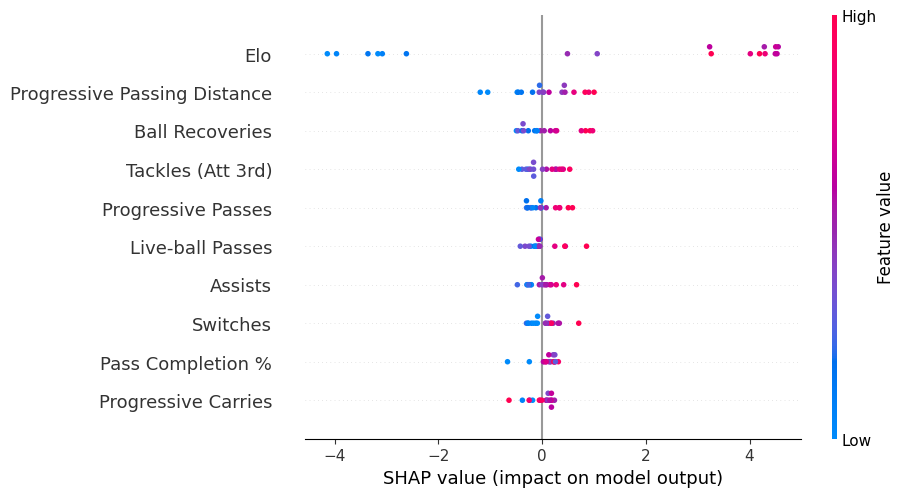

In [13]:
import shap
import numpy as np
import pandas as pd

# Extract model and transformed data
xgb_model = xgb_pipeline.named_steps["regressor"]
X_transformed = xgb_pipeline.named_steps["preprocessor"].transform(X_test)

# Extract feature names used in preprocessing
feature_names = xgb_pipeline.named_steps["preprocessor"].transformers_[0][2]

# Convert transformed data to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_transformed_df)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_abs_shap)[-10:]

# Filter SHAP values to top 10 features
shap_values_top = shap_values[:, top_10_indices]

# Plot SHAP summary (beeswarm) for top 10 features
shap.plots.beeswarm(shap_values_top)


### Modelling Results 

In [14]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by MAE (ascending)
results_df_sorted = results_df.sort_values(by="MAE", ascending=True)

# Display selected columns (optional)
display_cols = ["Model", "MAE", "RMSE", "5-CV", "R2"]
print(results_df_sorted[display_cols])

                            Model       MAE      RMSE      5-CV        R2
0                           Lasso  1.756870  2.281759  2.289085  0.770586
2  ElasticNet (Top15 SelectKBest)  1.944130  2.373385  2.325761  0.753667
4           RandomForest (Optuna)  2.306843  2.855534  2.645344  0.640702
1                   Lasso+XGBoost  2.311402  2.856313  2.861597  0.640506
5                XGBoost (Optuna)  2.441835  3.226412  2.632347  0.541309
3    ElasticNet→XGBoost (Stacked)  2.518869  3.616792 -3.029380  0.423595


### Model Saving & Shap Plots

In [16]:
import joblib

# Get the best model (lowest MAE)
best_model = results_df_sorted.iloc[0]["Pipeline"]

# Save to disk
joblib.dump(best_model, "best_model_fb.joblib")

['best_model_fb.joblib']

Feature names: 27, Coefs: 27
                          feature  coefficient
26                            Elo     3.637513
12   Progressive Passing Distance     0.426180
18              Tackles (Att 3rd)     0.413102
2       Crosses into Penalty Area     0.347746
25                Ball Recoveries     0.306107
8        Pass Completion % (Long)     0.229693
20           SCA (Live-ball Pass)     0.162696
21                Fouls Committed    -0.092908
14                  Through Balls     0.067168
0                         Assists     0.041084
10        Passes Attempted (Long)     0.000000
19            Dribbles Challenged    -0.000000
3             Progressive Carries     0.000000
24                         Errors     0.000000
23                    Aerials Won    -0.000000
22                    Fouls Drawn    -0.000000
4   Progressive Carrying Distance     0.000000
5        Carries into Final Third     0.000000
6               Touches (Att 3rd)     0.000000
11             Progressive Pass

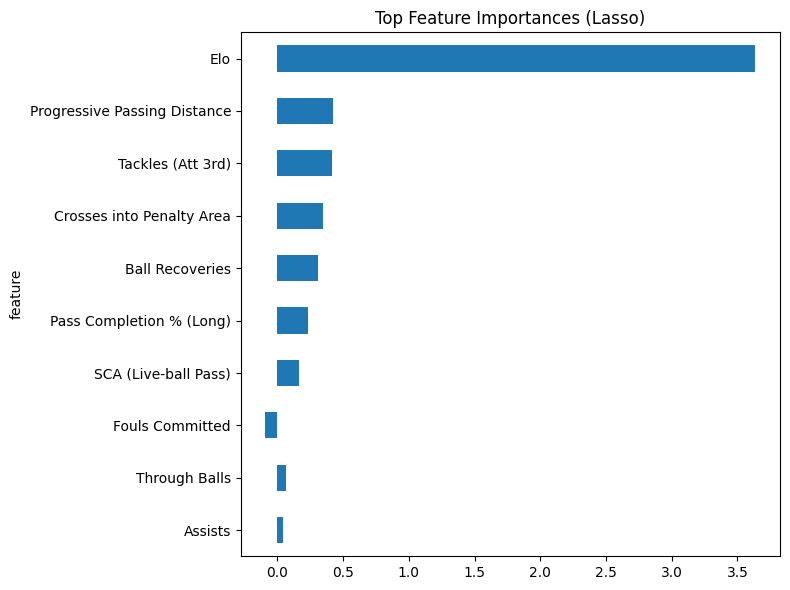

In [19]:
import matplotlib.pyplot as plt

# Access the fitted pipeline and components
preprocessor = best_model.named_steps['preprocess']

# Get feature names in the order passed to the 'num' transformer
feature_names = preprocessor.transformers_[0][2]

# Access the Lasso model (adapt name if needed)
lasso = (
    best_model.named_steps['lasso']
    if 'lasso' in best_model.named_steps
    else best_model[-1]
)

# Get coefficients
coefs = lasso.coef_

# Sanity check
print(f"Feature names: {len(feature_names)}, Coefs: {len(coefs)}")

# DataFrame for importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=np.abs, ascending=False)

print(importance_df)

# Optional: Plot top 10
importance_df.head(10).plot(
    x='feature', y='coefficient', kind='barh', figsize=(8,6), legend=False
)
plt.title('Top Feature Importances (Lasso)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


/Users/ghalichraibi/anaconda3/lib/python3.11/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


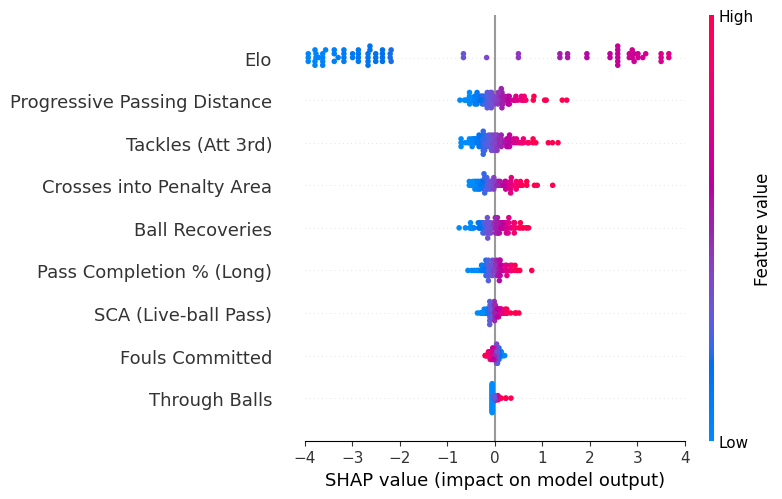

In [22]:
import shap

# Transform X as model sees it
X_proc = preprocessor.transform(X_train[feature_names])

# SHAP for linear models
explainer = shap.LinearExplainer(lasso, X_proc, feature_perturbation="interventional")
shap_values = explainer(X_proc)

plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values,
    features=X_proc,
    feature_names=feature_names,
    show=False,
    max_display=9  # Adjust for top N features
)
plt.xlim(-4, 4)  # Adjust limits as needed
plt.show()